In [41]:
from unittest.mock import inplace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from keras.src.callbacks import EarlyStopping
import random
import numpy as np
import tensorflow as tf
from keras.api.layers import Dense, Dropout
from keras.api.models import Sequential
from keras.api.regularizers import l1, l2
from keras.api.optimizers import Adam

In [42]:
def set_seeds(seed = 100):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    
def cw(df):
    c0, c1 = np.bincount(df["dir"])
    w0 = (1/c0) * (len(df)) / 2
    w1 = (1/c1) * (len(df)) / 2
    return {0:w0, 1:w1}

In [43]:
symbol = "EURUSD=X"
start = "2004-01-01"
end = "2024-08-22"
interval = '1d'
ptc = 0.000059
lags = 7

In [44]:
df = yf.download(symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
df.drop(columns=['Adj Close', 'Volume'], inplace=True)
#df.index = df.index.tz_convert('utc')
df['returns'] = np.log(df['Close'].div(df['Close'].shift(1)))
df['day_of_week'] = df.index.dayofweek
df['dir'] = np.where(df['returns'] > 0, 1,0)
df.dropna(inplace=True)
features = ["dir", 'Open', 'High', 'Low', 'Close', 'returns']
df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,returns,day_of_week,dir
Date,,,,,,,
2004-01-02,1.258194,1.262802,1.252693,1.258194,0.000000,4,0
2004-01-05,1.263903,1.269406,1.263695,1.268698,0.008313,0,1
2004-01-06,1.268907,1.280803,1.267202,1.272103,0.002681,1,1
2004-01-07,1.272394,1.273999,1.262499,1.264095,-0.006315,2,0
2004-01-08,1.264095,1.278707,1.256502,1.277498,0.010547,3,1
...,...,...,...,...,...,...,...
2024-08-15,1.101322,1.101686,1.095050,1.101322,0.001475,3,1
2024-08-16,1.097273,1.100437,1.097370,1.097273,-0.003683,4,0
2024-08-19,1.102499,1.107260,1.102390,1.102499,0.004752,0,1


In [45]:
tnx_symbol = "^TNX"

tnx = yf.download(tnx_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
tnx.drop(columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'], inplace=True)
#df.index = df.index.tz_convert('utc')
tnx.rename(columns={'Close': 'tnx_close'}, inplace=True)
tnx['tnx_returns'] = np.log(tnx['tnx_close'].div(tnx['tnx_close'].shift(1)))
tnx.dropna(inplace=True)
tnx

[*********************100%%**********************]  1 of 1 completed


,tnx_close,tnx_returns
Date,,
2004-01-05,4.387,0.003196
2004-01-06,4.277,-0.025394
2004-01-07,4.246,-0.007274
2004-01-08,4.249,0.000706
2004-01-09,4.086,-0.039117
...,...,...
2024-08-15,3.926,0.027371
2024-08-16,3.892,-0.008698
2024-08-19,3.867,-0.006444


In [46]:
forex_combined = tnx.join(df, how='outer')
forex_combined

,tnx_close,tnx_returns,Open,High,Low,Close,returns,day_of_week,dir
Date,,,,,,,,,
2004-01-02,NaN,NaN,1.258194,1.262802,1.252693,1.258194,0.000000,4.0,0.0
2004-01-05,4.387,0.003196,1.263903,1.269406,1.263695,1.268698,0.008313,0.0,1.0
2004-01-06,4.277,-0.025394,1.268907,1.280803,1.267202,1.272103,0.002681,1.0,1.0
2004-01-07,4.246,-0.007274,1.272394,1.273999,1.262499,1.264095,-0.006315,2.0,0.0
2004-01-08,4.249,0.000706,1.264095,1.278707,1.256502,1.277498,0.010547,3.0,1.0
...,...,...,...,...,...,...,...,...,...
2024-08-15,3.926,0.027371,1.101322,1.101686,1.095050,1.101322,0.001475,3.0,1.0
2024-08-16,3.892,-0.008698,1.097273,1.100437,1.097370,1.097273,-0.003683,4.0,0.0
2024-08-19,3.867,-0.006444,1.102499,1.107260,1.102390,1.102499,0.004752,0.0,1.0


In [47]:
snp_symbol = "^SPX"

snp = yf.download(snp_symbol, start, end, interval=interval)
#df.rename(columns={"Close": "price"}, inplace=True)
snp.drop(columns=['Adj Close', 'Volume', 'Open', 'High', 'Low'], inplace=True)
#df.index = df.index.tz_convert('utc')
snp.rename(columns={'Close': 'snp_close'}, inplace=True)
snp['snp_returns'] = np.log(snp['snp_close'].div(snp['snp_close'].shift(1)))
snp.dropna(inplace=True)
snp

[*********************100%%**********************]  1 of 1 completed


,snp_close,snp_returns
Date,,
2004-01-05,1122.219971,0.012319
2004-01-06,1123.670044,0.001291
2004-01-07,1126.329956,0.002364
2004-01-08,1131.920044,0.004951
2004-01-09,1121.859985,-0.008927
...,...,...
2024-08-15,5543.220215,0.016004
2024-08-16,5554.250000,0.001988
2024-08-19,5608.250000,0.009675


In [48]:
forex_combined = snp.join(forex_combined, how='outer')
forex_combined

,snp_close,snp_returns,tnx_close,tnx_returns,Open,High,Low,Close,returns,day_of_week,dir
Date,,,,,,,,,,,
2004-01-02,NaN,NaN,NaN,NaN,1.258194,1.262802,1.252693,1.258194,0.000000,4.0,0.0
2004-01-05,1122.219971,0.012319,4.387,0.003196,1.263903,1.269406,1.263695,1.268698,0.008313,0.0,1.0
2004-01-06,1123.670044,0.001291,4.277,-0.025394,1.268907,1.280803,1.267202,1.272103,0.002681,1.0,1.0
2004-01-07,1126.329956,0.002364,4.246,-0.007274,1.272394,1.273999,1.262499,1.264095,-0.006315,2.0,0.0
2004-01-08,1131.920044,0.004951,4.249,0.000706,1.264095,1.278707,1.256502,1.277498,0.010547,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-08-15,5543.220215,0.016004,3.926,0.027371,1.101322,1.101686,1.095050,1.101322,0.001475,3.0,1.0
2024-08-16,5554.250000,0.001988,3.892,-0.008698,1.097273,1.100437,1.097370,1.097273,-0.003683,4.0,0.0
2024-08-19,5608.250000,0.009675,3.867,-0.006444,1.102499,1.107260,1.102390,1.102499,0.004752,0.0,1.0


In [49]:
features = ['Open', 'High', 'Low', 'Close', 'returns', 'day_of_week', 'snp_close', 'snp_returns', 'tnx_close', 'tnx_returns']

In [51]:
copy = forex_combined.copy()
cols = []
for f in features:
    for lag in range(1, lags + 1):
        col = "{}_lag_{}".format(f, lag)
        copy[col] = copy[f].shift(lag)
        cols.append(col)
copy.dropna(inplace=True)

split = int(len(copy)* 0.8)
train = copy.iloc[:split].copy()
test = copy.iloc[split:].copy()
mu, std = train.mean(), train.std()
train_standardized = (train-mu) / std

In [52]:
### Parameters
dropout = 0.3

In [53]:
optimizer = Adam(learning_rate = 0.0001)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

set_seeds(100)
model = Sequential()
model.add(Dense(32, input_dim = len(cols), activity_regularizer = None ,activation = "relu", kernel_regularizer=l2(0.001), )) 
model.add(Dropout(dropout, seed = 100))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))
model.add(Dense(32, activation = "relu", activity_regularizer = None, kernel_regularizer=l2(0.001),))    
model.add(Dropout(dropout, seed = 100))        
model.add(Dense(1, activation = "sigmoid")) 
model.compile(loss = "binary_crossentropy", optimizer = optimizer, metrics = ["accuracy"])

model.fit(x=train_standardized[cols], y=train['dir'], epochs=30, verbose=False,
          validation_split=0.2, shuffle=False, class_weight=cw(train), callbacks=[early_stopping] )


C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\code\trading\v1\pythonProject\.venv\Lib\site-packages\keras\src\trainers\data_adapters\data_adapter_utils.py:126: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_weight[i] = class_weight.get(int(y[i]), 1.0)


In [54]:
loss_train, accuracy_train =  model.evaluate(train_standardized[cols], train['dir'])
predict = model.predict(train_standardized[cols])

test_standardized = (test-mu) / std
loss_test, accuracy_test =  model.evaluate(test_standardized[cols], test['dir'])
test['probability'] = model.predict(test_standardized[cols])
threshold = 0.53
test['position'] = np.where(test.probability < (1-threshold), -1, np.nan)
test['position'] = np.where(test.probability > threshold, 1, test.position)
test['position'] = test.position.ffill()
test['strategy'] = test['position'] * test['returns']
test['creturns'] = test['returns'].cumsum().apply(np.exp)
test['cstrategy'] = test['strategy'].cumsum().apply(np.exp)
test['trades'] = test.position.diff().abs()
test['strategy_net'] = test.strategy - test.trades * ptc
test['cstrategy_net'] = test['strategy_net'].cumsum().apply(np.exp)

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 554us/step - accuracy: 0.5652 - loss: 0.7707
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 987us/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 871us/step - accuracy: 0.5102 - loss: 0.7805
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 828us/step


In [55]:
print(f"Loss: {loss_train}")
print(f"Accuracy: {accuracy_train}")

Loss: 0.7705130577087402
Accuracy: 0.5649157762527466


In [56]:
print(f"Loss: {loss_test}")
print(f"Accuracy: {accuracy_test}")

Loss: 0.7779780626296997
Accuracy: 0.5125495195388794


<Axes: >

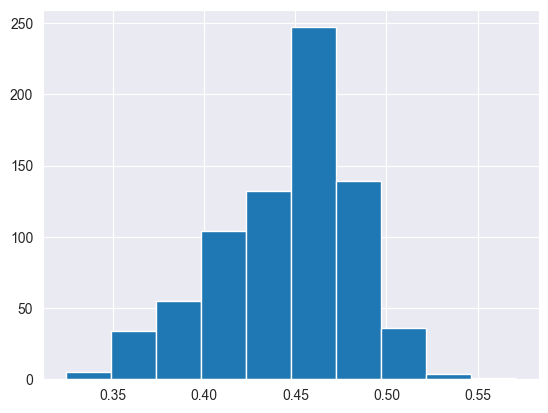

In [57]:
test.probability.hist()

95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 495us/step


<Axes: xlabel='Date'>

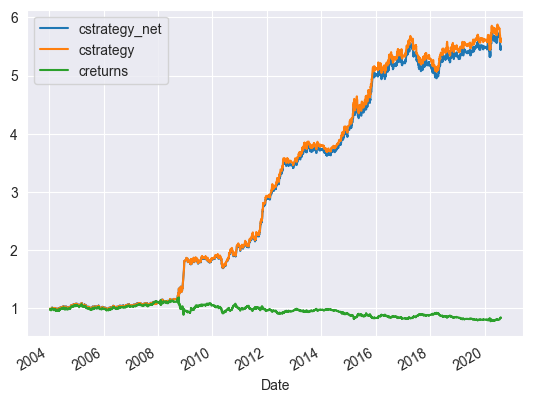

In [58]:
train['probability'] = model.predict(train_standardized[cols])
threshold = 0.53
train['position'] = np.where(train.probability < (1-threshold), -1, np.nan)
train['position'] = np.where(train.probability > threshold, 1, train.position)
train['position'] = train.position.ffill()
train['strategy'] = train['position'] * train['returns']
train['creturns'] = train['returns'].cumsum().apply(np.exp)
train['cstrategy'] = train['strategy'].cumsum().apply(np.exp)
train['trades'] = train.position.diff().abs()
train['strategy_net'] = train.strategy - train.trades * ptc
train['cstrategy_net'] = train['strategy_net'].cumsum().apply(np.exp)
train[['cstrategy_net', 'cstrategy', 'creturns']].plot()

<Axes: xlabel='Date'>

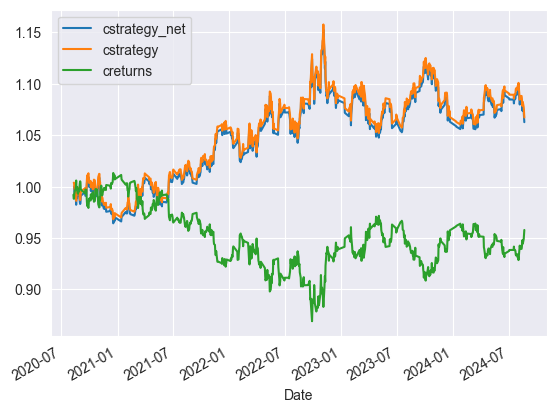

In [59]:
test[['cstrategy_net', 'cstrategy', 'creturns']].plot()

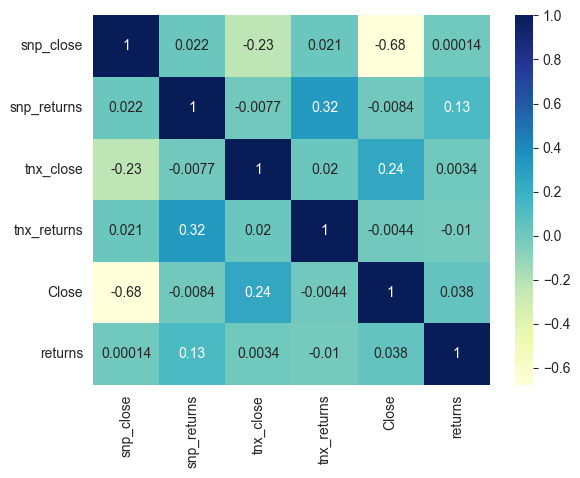

In [69]:
import seaborn as sns
%matplotlib inline

forex_clean = forex_combined.copy()
forex_clean.drop(columns=['Open', 'High', 'Low', 'day_of_week', 'dir'], inplace=True)

dataplot = sns.heatmap(forex_clean.corr(), cmap="YlGnBu", annot=True) 